In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve

In [2]:
N = 50  # Number of grid points in each direction (N x N grid)
L = 1.0 # Domain size [0, L] x [0, L]
h = L / (N - 1) 
a = 1.0
b = 2.0

print(f"Total nodes: {N*N}")
print(f"Step size h: {h}")


Total nodes: 2500
Step size h: 0.02040816326530612


In [3]:
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
X, Y = np.meshgrid(x, y)

N_internal = N - 2
total_internal_nodes = N_internal * N_internal

In [4]:
def source_term(x, y, a, b):
    return x * np.sin(a * np.pi * y) + y * np.sin(b * np.pi * x)

f = np.zeros((N_internal, N_internal))
for i in range(N_internal):
    for j in range(N_internal):
        x_coord = x[i + 1] # x coordinates skip the 0 boundary
        y_coord = y[j + 1] # y coordinates skip the 0 boundary
        f[i, j] = source_term(x_coord, y_coord, a, b)

# Flatten f into a vector for the linear system Ax = f_vec
f_vec = f.flatten()

In [5]:
# Use List of Lists format for efficient sparse matrix construction
A = lil_matrix((total_internal_nodes, total_internal_nodes))

# Fill the matrix based on the 5-point stencil
for i in range(N_internal): # Corresponds to x index
    for j in range(N_internal): # Corresponds to y index
        row_idx = i * N_internal + j # Global index for node (i, j)

        # Diagonal element (4 * u_ij)
        A[row_idx, row_idx] = 4

        # Off-diagonal elements (-1 * neighbors)
        if i > 0: # Neighbor (i-1, j)
            A[row_idx, (i - 1) * N_internal + j] = -1
        if i < N_internal - 1: # Neighbor (i+1, j)
            A[row_idx, (i + 1) * N_internal + j] = -1
        if j > 0: # Neighbor (i, j-1)
            A[row_idx, i * N_internal + (j - 1)] = -1
        if j < N_internal - 1: # Neighbor (i, j+1)
            A[row_idx, i * N_internal + (j + 1)] = -1

# Scale by 1/h^2
A = A / (h**2)

# Convert to Compressed Sparse Column format for efficient solving
A_csc = A.tocsc()

print(f"Matrix A shape: {A_csc.shape}")

Matrix A shape: (2304, 2304)


In [6]:
# Solve A * u_vec = f_vec for the interior solution u_vec
u_vec = spsolve(A_csc, f_vec)

print("Linear system solved.")

Linear system solved.


In [7]:
# Reshape the flat vector u_vec back into a 2D grid for the interior
u_internal = u_vec.reshape((N_internal, N_internal))

# Create the full solution grid (N x N) and fill with zeros
u_full = np.zeros((N, N))

# Insert the calculated interior solution
u_full[1:-1, 1:-1] = u_internal

# The boundaries remain 0 as per the problem definition [cite: 1]

print("Full solution grid created.")

Full solution grid created.


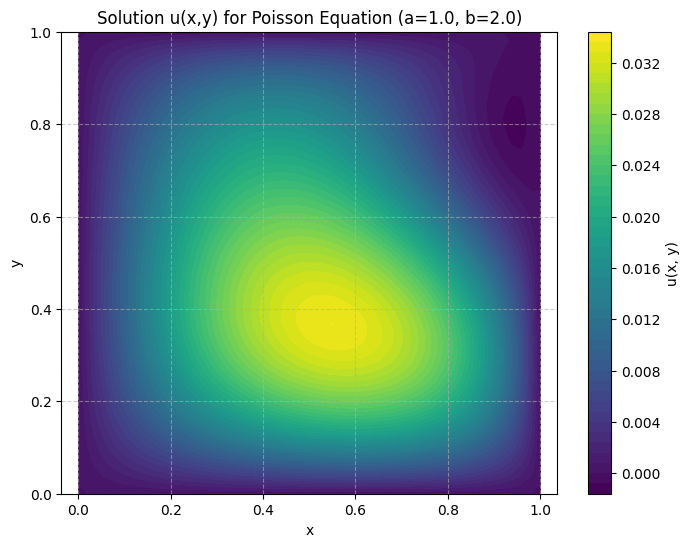

In [8]:
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, u_full, 50, cmap='viridis') # Use contourf for filled contours
plt.colorbar(contour, label='u(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Solution u(x,y) for Poisson Equation (a={a}, b={b})')
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(f'figure_solution_exemple.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
import time

# Define ranges for a and b
a_values = np.linspace(0.5, 3.0, 10) # Example: 10 values for a
b_values = np.linspace(0.5, 3.0, 10) # Example: 10 values for b

dataset_inputs = []
dataset_outputs = []

# --- Re-use Finite Difference Solver Code ---
# (Include functions/logic from Cells 2-7 here, parameterized by a, b)

def solve_poisson_for_ab(a_val, b_val, N=50):
    # --- Paste or adapt code from Cells 2-7 ---
    # Parameters
    L = 1.0
    h = L / (N - 1)
    N_internal = N - 2
    total_internal_nodes = N_internal * N_internal
    x = np.linspace(0, L, N)
    y = np.linspace(0, L, N)

    # Source term
    f = np.zeros((N_internal, N_internal))
    for i in range(N_internal):
        for j in range(N_internal):
            x_coord = x[i + 1]
            y_coord = y[j + 1]
            f[i, j] = source_term(x_coord, y_coord, a_val, b_val) # Use a_val, b_val
    f_vec = f.flatten()

    # Matrix A (Construct only once if N is fixed)
    # We can optimize this later, for now, let's assume we reconstruct it
    # Or better: define A construction outside the loop if N is constant
    A = lil_matrix((total_internal_nodes, total_internal_nodes))
    for i in range(N_internal):
        for j in range(N_internal):
            row_idx = i * N_internal + j
            A[row_idx, row_idx] = 4
            if i > 0: A[row_idx, (i - 1) * N_internal + j] = -1
            if i < N_internal - 1: A[row_idx, (i + 1) * N_internal + j] = -1
            if j > 0: A[row_idx, i * N_internal + (j - 1)] = -1
            if j < N_internal - 1: A[row_idx, i * N_internal + (j + 1)] = -1
    A = A / (h**2)
    A_csc = A.tocsc()

    # Solve
    u_vec = spsolve(A_csc, f_vec)

    # Reshape
    u_internal = u_vec.reshape((N_internal, N_internal))
    u_full = np.zeros((N, N))
    u_full[1:-1, 1:-1] = u_internal
    # --- End of adapted code ---

    return u_full # Return the full solution grid

# --- Loop to generate data ---
start_time = time.time()
count = 0
total_simulations = len(a_values) * len(b_values)

print(f"Generating {total_simulations} simulations...")

for a_val in a_values:
    for b_val in b_values:
        # Solve for this (a, b) pair
        u_solution = solve_poisson_for_ab(a_val, b_val, N=N)

        # Store input (a, b) and output u_solution
        dataset_inputs.append([a_val, b_val])
        # Store the flattened interior solution (common practice for ML)
        # u_interior_flat = u_solution[1:-1, 1:-1].flatten()
        # Alternatively, store the full flattened solution
        u_full_flat = u_solution.flatten()
        dataset_outputs.append(u_full_flat)

        count += 1
        if count % 10 == 0:
            print(f"Generated {count}/{total_simulations} simulations...")

end_time = time.time()
print(f"Dataset generation finished. Time taken: {end_time - start_time:.2f} seconds")

# Convert lists to numpy arrays
X_data = np.array(dataset_inputs)
Y_data = np.array(dataset_outputs)

print(f"Input data shape (X_data): {X_data.shape}") # Should be (num_samples, 2)
print(f"Output data shape (Y_data): {Y_data.shape}") # Should be (num_samples, N*N)

Generating 100 simulations...
Generated 10/100 simulations...
Generated 20/100 simulations...
Generated 30/100 simulations...
Generated 40/100 simulations...
Generated 50/100 simulations...
Generated 60/100 simulations...
Generated 70/100 simulations...
Generated 80/100 simulations...
Generated 90/100 simulations...
Generated 100/100 simulations...
Dataset generation finished. Time taken: 3.59 seconds
Input data shape (X_data): (100, 2)
Output data shape (Y_data): (100, 2500)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



# Model parameters
input_size = X_data.shape[1] # Should be 2
output_size = Y_data.shape[1] # Should be N*N

# Define the Neural Network architecture
class PoissonNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoissonNet, self).__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 512)
        self.layer_out = nn.Linear(512, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x) # No activation for regression output
        return x

# Instantiate the model
model = PoissonNet(input_size, output_size)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)
print(f"Model moved to device: {device}")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

PoissonNet(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=2500, bias=True)
  (relu): ReLU()
)
Model moved to device: cuda


Training data shape: X=torch.Size([80, 2]), Y=torch.Size([80, 2500])
Validation data shape: X=torch.Size([20, 2]), Y=torch.Size([20, 2500])
Epoch [1/50], Train Loss: 0.0030, Val Loss: 0.0007
Epoch [2/50], Train Loss: 0.0005, Val Loss: 0.0005
Epoch [3/50], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [4/50], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [5/50], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [6/50], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [7/50], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [8/50], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [9/50], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [10/50], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [11/50], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [12/50], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [13/50], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [14/50], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [15/50], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [16/50], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [17/50], Train Loss: 0.0000, Va

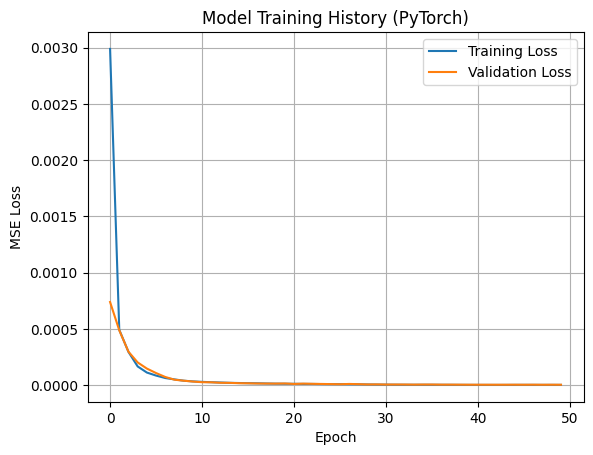

In [11]:
from sklearn.model_selection import train_test_split

# Split data (using sklearn is fine)
X_train_np, X_val_np, Y_train_np, Y_val_np = train_test_split(
    X_data, Y_data, test_size=0.2, random_state=42
)

# Convert NumPy arrays to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32).to(device)

# Create TensorDatasets and DataLoaders
batch_size = 16 # Adjust as needed

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training data shape: X={X_train.shape}, Y={Y_train.shape}")
print(f"Validation data shape: X={X_val.shape}, Y={Y_val.shape}")

# Training parameters
epochs = 50 # Adjust as needed

# Lists to store loss history
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train() # Set model to training mode
    running_train_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        # Move data to device already done when creating tensors
        # inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            # inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")


print("Training finished.")

# Plot training history
plt.figure()
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Model Training History (PyTorch)')
plt.grid(True)
plt.savefig('figure_loss_history.png', dpi=300, bbox_inches='tight')
plt.show()

Reconstructed matrix A for residual calculation.
Predictions generated for 20 validation samples.
Shape of predictions (Y_pred): (20, 2500)
Shape of true values (Y_true): (20, 2500)

Data Error Metrics (on validation set):
  Mean Squared Error (MSE): 0.000004
  Mean Absolute Error (MAE): 0.001493

Physical Criterion (on validation set):
  Average L2 Norm of PDE Residual: 12.677061

Visualizing 3 examples (Best, Median, Worst MSE)...


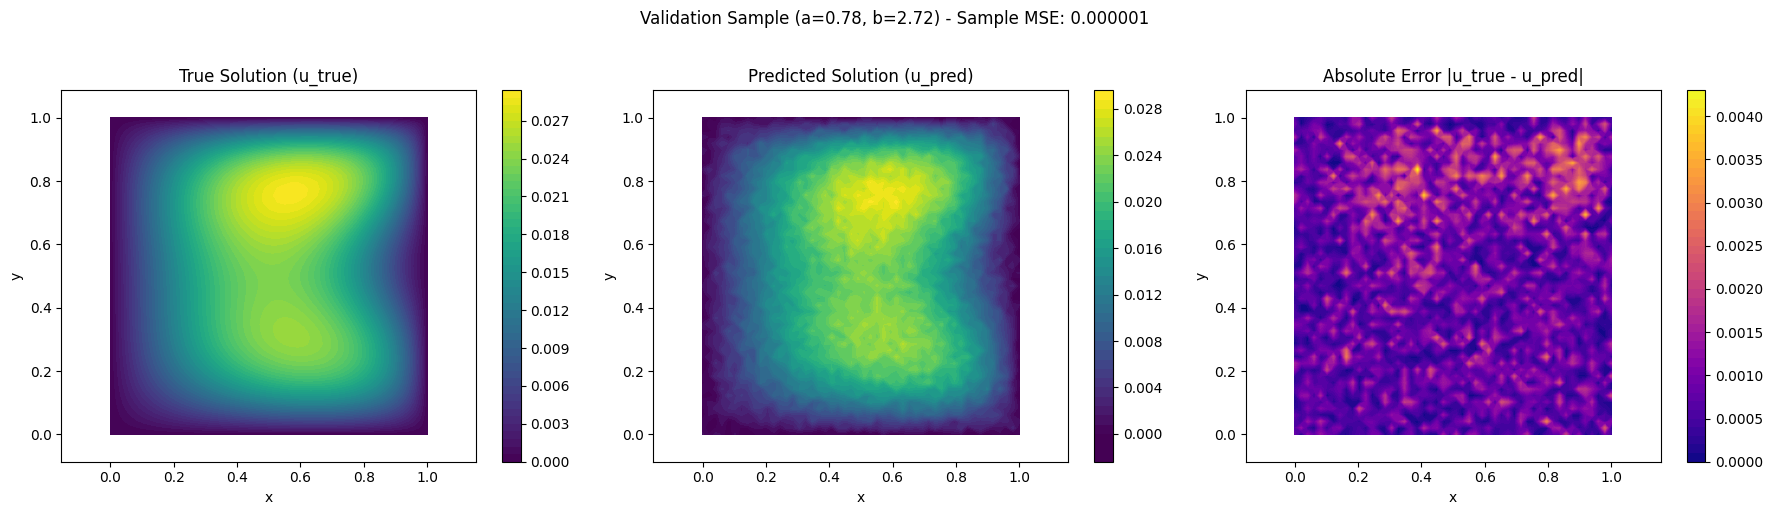

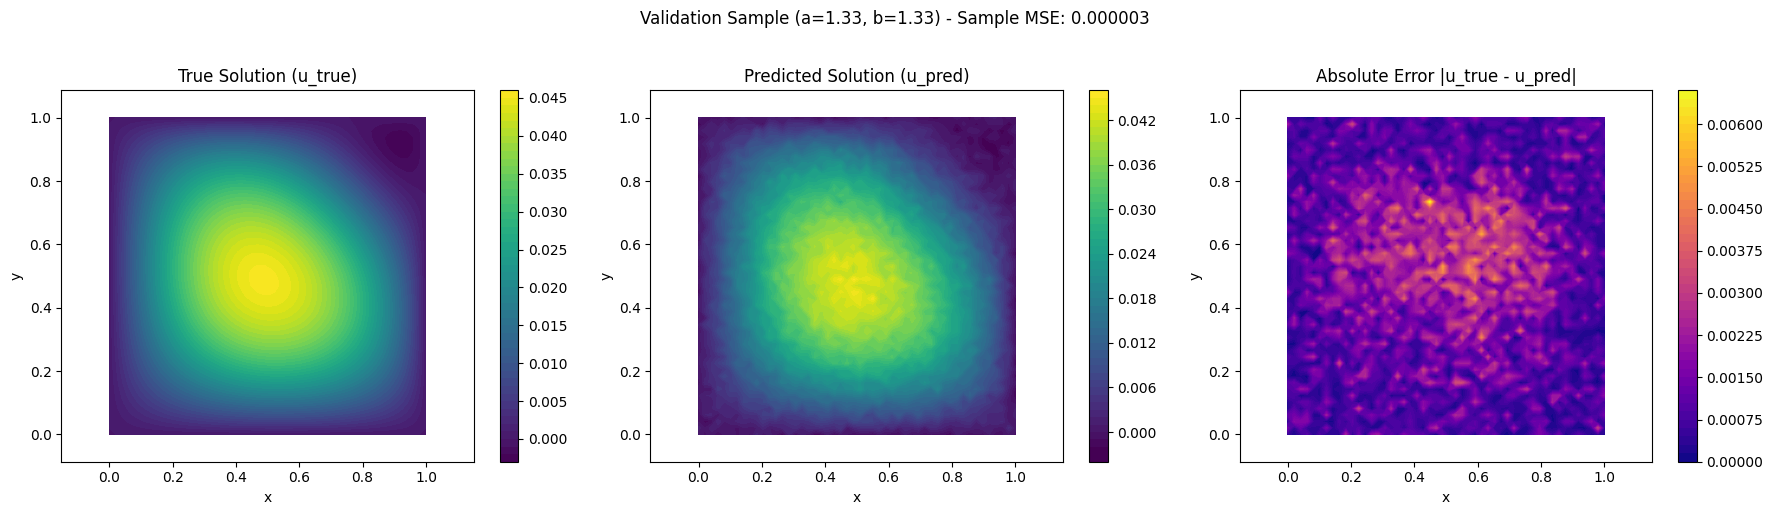

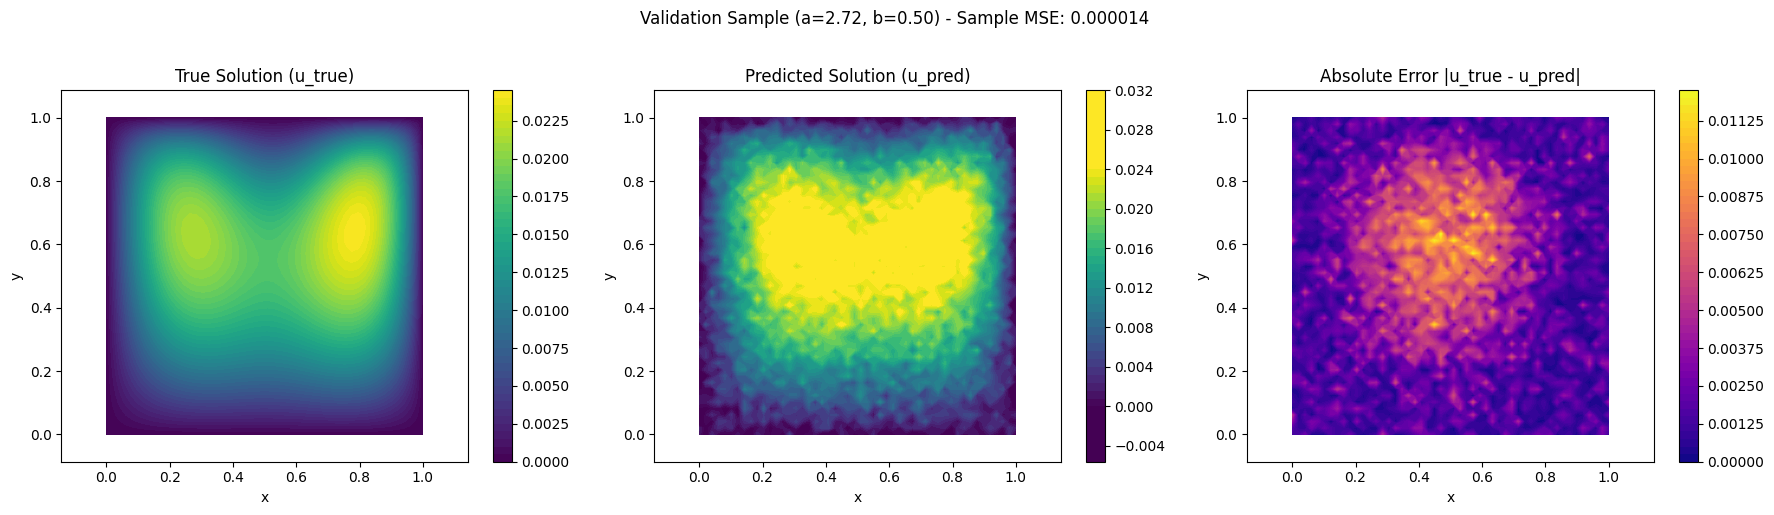

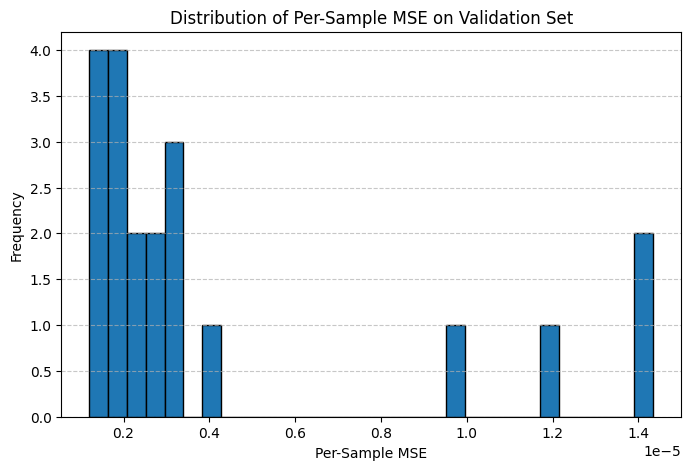


Statistics for Per-Sample MSE:
  Mean: 0.000004
  Std Dev: 0.000004
  Min: 0.000001
  Max: 0.000014


In [12]:
# Cell 12: Evaluate the Model (PyTorch)
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csc_matrix

# --- Make sure model, X_val, Y_val, device, N, h are defined ---

# --- 0. Reconstruct the Finite Difference Matrix A (if not stored) ---
# This matrix represents the negative Laplacian operator scaled by 1/h^2
# Needed for the residual calculation.
N_internal = N - 2
total_internal_nodes = N_internal * N_internal

A_eval = lil_matrix((total_internal_nodes, total_internal_nodes))
for i in range(N_internal):
    for j in range(N_internal):
        row_idx = i * N_internal + j
        A_eval[row_idx, row_idx] = 4
        if i > 0: A_eval[row_idx, (i - 1) * N_internal + j] = -1
        if i < N_internal - 1: A_eval[row_idx, (i + 1) * N_internal + j] = -1
        if j > 0: A_eval[row_idx, i * N_internal + (j - 1)] = -1
        if j < N_internal - 1: A_eval[row_idx, i * N_internal + (j + 1)] = -1
A_eval = A_eval / (h**2)
A_eval_csc = A_eval.tocsc() # Use CSC format

# Convert sparse scipy matrix to sparse torch tensor (requires torch >= 1. sparse)
# Note: Ensure you have a recent PyTorch version supporting sparse tensors well.
# Alternatively, convert A_eval_csc to dense if N is small enough, but beware of memory.
# Let's proceed assuming recent PyTorch or we'll handle it during calculation.
# If using older PyTorch or facing issues, converting A to dense might be needed:
# A_dense_torch = torch.tensor(A_eval_csc.toarray(), dtype=torch.float32).to(device)

print("Reconstructed matrix A for residual calculation.")

# --- 1. Get Model Predictions on Validation Set ---
model.eval() # Set model to evaluation mode
all_predictions = []
with torch.no_grad(): # Turn off gradients for evaluation
    # Process validation data in batches if it's large
    # For simplicity, if X_val fits in memory, predict all at once:
    Y_pred_tensor = model(X_val)
    # If using DataLoader for validation:
    # for inputs, _ in val_loader: # We only need inputs here
    #    outputs = model(inputs)
    #    all_predictions.append(outputs)
    # Y_pred_tensor = torch.cat(all_predictions, dim=0)


# Move predictions to CPU and convert to NumPy for easier handling/plotting
Y_pred = Y_pred_tensor.cpu().numpy()
Y_true = Y_val.cpu().numpy() # Assuming Y_val is the ground truth from validation set
X_params = X_val.cpu().numpy() # Get the corresponding (a, b) parameters

print(f"Predictions generated for {len(Y_pred)} validation samples.")
print(f"Shape of predictions (Y_pred): {Y_pred.shape}")
print(f"Shape of true values (Y_true): {Y_true.shape}")


# --- 2. Calculate Data Error Metrics ---
mse = np.mean((Y_true - Y_pred)**2)
mae = np.mean(np.abs(Y_true - Y_pred))

print(f"\nData Error Metrics (on validation set):")
print(f"  Mean Squared Error (MSE): {mse:.6f}")
print(f"  Mean Absolute Error (MAE): {mae:.6f}")

# --- 3. Calculate Physical Criterion (PDE Residual) ---
# This requires applying the discrete Laplacian (A) to the *predicted* solution
# and comparing it to the *true* source term f corresponding to the input (a,b).

# Define source term function again (from Cell 4)
def source_term(x, y, a, b):
    return x * np.sin(a * np.pi * y) + y * np.sin(b * np.pi * x)

x_grid = np.linspace(0, 1.0, N)
y_grid = np.linspace(0, 1.0, N)

residual_norms = []

for k in range(len(X_params)):
    a_k, b_k = X_params[k] # Get input parameters (a, b) for this sample

    # Get the predicted solution (flattened N*N) and extract interior points
    u_pred_flat = Y_pred[k]
    u_pred_grid = u_pred_flat.reshape((N, N))
    u_pred_interior_flat = u_pred_grid[1:-1, 1:-1].flatten() # Shape: (M,)

    # Apply the discrete Laplacian A to the predicted interior solution
    # f_pred_vec = A_eval_csc @ u_pred_interior_flat # Matrix multiplication
    # Handle potential sparse tensor conversion issues - using dense temporarily if needed
    A_dense = A_eval_csc.toarray()
    f_pred_vec = A_dense @ u_pred_interior_flat

    # Calculate the true source term f on the interior grid for (a_k, b_k)
    f_true = np.zeros((N_internal, N_internal))
    for i in range(N_internal):
        for j in range(N_internal):
            x_coord = x_grid[i + 1]
            y_coord = y_grid[j + 1]
            f_true[i, j] = source_term(x_coord, y_coord, a_k, b_k)
    f_true_vec = f_true.flatten() # Shape: (M,)

    # Calculate the residual vector
    residual_vec = f_true_vec - f_pred_vec # Shape: (M,)

    # Calculate the L2 norm of the residual vector for this sample
    residual_norm_k = np.linalg.norm(residual_vec) / np.sqrt(len(residual_vec)) # Normalize per node
    residual_norms.append(residual_norm_k)

# Calculate the average residual norm across the validation set
avg_residual_norm = np.mean(residual_norms)

print(f"\nPhysical Criterion (on validation set):")
print(f"  Average L2 Norm of PDE Residual: {avg_residual_norm:.6f}")


# --- 4. Visualize Predictions ---
# Select a few examples (e.g., best, worst, random) based on MSE
num_samples_to_plot = 3
sample_mses = np.mean((Y_true - Y_pred)**2, axis=1) # MSE per sample
sorted_indices = np.argsort(sample_mses)

plot_indices = [sorted_indices[0], # Best
                sorted_indices[len(sorted_indices)//2], # Median
                sorted_indices[-1]] # Worst

print(f"\nVisualizing {num_samples_to_plot} examples (Best, Median, Worst MSE)...")

X_plot, Y_plot = np.meshgrid(x_grid, y_grid) # Grid for plotting

for idx in plot_indices:
    u_true_grid = Y_true[idx].reshape((N, N))
    u_pred_grid = Y_pred[idx].reshape((N, N))
    error_grid = np.abs(u_true_grid - u_pred_grid)
    a_plot, b_plot = X_params[idx]
    sample_mse = sample_mses[idx]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Validation Sample (a={a_plot:.2f}, b={b_plot:.2f}) - Sample MSE: {sample_mse:.6f}", y=1.02)

    # Plot True Solution
    cf1 = axes[0].contourf(X_plot, Y_plot, u_true_grid, 50, cmap='viridis')
    fig.colorbar(cf1, ax=axes[0])
    axes[0].set_title('True Solution (u_true)')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].axis('equal')

    # Plot Predicted Solution
    cf2 = axes[1].contourf(X_plot, Y_plot, u_pred_grid, 50, cmap='viridis', vmin=u_true_grid.min(), vmax=u_true_grid.max()) # Use same scale
    fig.colorbar(cf2, ax=axes[1])
    axes[1].set_title('Predicted Solution (u_pred)')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].axis('equal')

    # Plot Absolute Error
    cf3 = axes[2].contourf(X_plot, Y_plot, error_grid, 50, cmap='plasma')
    fig.colorbar(cf3, ax=axes[2])
    axes[2].set_title('Absolute Error |u_true - u_pred|')
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    axes[2].axis('equal')

    plt.tight_layout()
    plt.show()

# --- 5. Error Variability (Optional: Histogram of per-sample MSE) ---
plt.figure(figsize=(8, 5))
plt.hist(sample_mses, bins=30, edgecolor='black')
plt.xlabel('Per-Sample MSE')
plt.ylabel('Frequency')
plt.title('Distribution of Per-Sample MSE on Validation Set')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('figure_mse_histogram.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nStatistics for Per-Sample MSE:")
print(f"  Mean: {np.mean(sample_mses):.6f}")
print(f"  Std Dev: {np.std(sample_mses):.6f}")
print(f"  Min: {np.min(sample_mses):.6f}")
print(f"  Max: {np.max(sample_mses):.6f}")

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Fixed parameters for this PINN instance
a_pinn = 1.0
b_pinn = 2.0

# Define the source term function f(x, y) using torch for autograd compatibility
def source_term_torch(x, y, a, b):
    return x * torch.sin(a * torch.pi * y) + y * torch.sin(b * torch.pi * x)

Using device: cuda


In [23]:
class PINNNet(nn.Module):
    def __init__(self):
        super(PINNNet, self).__init__()
        # Input layer (x, y) -> Hidden layer 1
        self.fc1 = nn.Linear(2, 50) 
        # Hidden layer 1 -> Hidden layer 2
        self.fc2 = nn.Linear(50, 50)
        # Hidden layer 2 -> Hidden layer 3
        self.fc3 = nn.Linear(50, 50)
        # Hidden layer 3 -> Output layer (u)
        self.fc4 = nn.Linear(50, 1)
        # Activation function (tanh is common in PINNs)
        self.activation = nn.Tanh()

    def forward(self, x):
        # x is expected to be a tensor of shape [N, 2] where N is batch size
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x) # Linear output for regression
        return x

# Instantiate the network
pinn_model = PINNNet().to(device)
print(pinn_model)

PINNNet(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=1, bias=True)
  (activation): Tanh()
)


In [24]:
# Number of points
N_boundary = 100 # Number of points per boundary edge
N_pde = 10000    # Number of points inside the domain for PDE residual

# 1. Boundary points (where u=0)
# Top boundary (y=1)
x_top = torch.rand(N_boundary, 1, device=device)
y_top = torch.ones_like(x_top, device=device)
# Bottom boundary (y=0)
x_bottom = torch.rand(N_boundary, 1, device=device)
y_bottom = torch.zeros_like(x_bottom, device=device)
# Left boundary (x=0)
y_left = torch.rand(N_boundary, 1, device=device)
x_left = torch.zeros_like(y_left, device=device)
# Right boundary (x=1)
y_right = torch.rand(N_boundary, 1, device=device)
x_right = torch.ones_like(y_right, device=device)

# Concatenate boundary points
xy_boundary = torch.cat([
    torch.cat([x_top, y_top], dim=1),
    torch.cat([x_bottom, y_bottom], dim=1),
    torch.cat([x_left, y_left], dim=1),
    torch.cat([x_right, y_right], dim=1),
], dim=0)

# Target values for boundary points (u=0)
u_boundary_target = torch.zeros(xy_boundary.shape[0], 1, device=device)

# 2. PDE collocation points (inside the domain)
# Using Latin Hypercube Sampling might be better, but random is simpler for now
x_pde = torch.rand(N_pde, 1, device=device)
y_pde = torch.rand(N_pde, 1, device=device)
# Ensure these points require gradients for autograd
x_pde.requires_grad_(True)
y_pde.requires_grad_(True)
xy_pde = torch.cat([x_pde, y_pde], dim=1)

print(f"Boundary points shape: {xy_boundary.shape}")
print(f"PDE points shape: {xy_pde.shape}")

Boundary points shape: torch.Size([400, 2])
PDE points shape: torch.Size([10000, 2])


In [25]:
def pinn_loss_function(model, xy_b, u_b_target, xy_pde, a, b):
    # --- Boundary Loss ---
    model.eval() # Set model to eval mode for prediction consistency
    u_pred_b = model(xy_b)
    loss_bc = torch.mean((u_pred_b - u_b_target)**2)

    # --- PDE Residual Loss ---
    model.train() # Back to train mode to ensure gradients are tracked if needed later
    
    # Clone inputs to allow gradient computation
    x_pde = xy_pde[:, 0:1].clone().requires_grad_(True)
    y_pde = xy_pde[:, 1:2].clone().requires_grad_(True)
    
    # Combine for model input
    xy_pde_input = torch.cat([x_pde, y_pde], dim=1)

    # Predict u at PDE points
    u_pred_pde = model(xy_pde_input)

    # Calculate derivatives using autograd
    # First derivatives: u_x, u_y
    grads = torch.autograd.grad(u_pred_pde, xy_pde_input, 
                                grad_outputs=torch.ones_like(u_pred_pde), 
                                create_graph=True, retain_graph=True)[0]
    u_x = grads[:, 0:1]
    u_y = grads[:, 1:2]

    # Second derivatives: u_xx, u_yy
    u_xx = torch.autograd.grad(u_x, x_pde, 
                               grad_outputs=torch.ones_like(u_x), 
                               create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_pde, 
                               grad_outputs=torch.ones_like(u_y), 
                               create_graph=True, retain_graph=True)[0] # Retain graph if needed elsewhere

    # Laplacian: laplacian_u = u_xx + u_yy
    laplacian_u = u_xx + u_yy

    # Calculate source term f at PDE points
    f_pde = source_term_torch(x_pde, y_pde, a, b)

    # Calculate PDE residual: R = -laplacian_u - f
    # Note: Original PDE is -laplacian_u = f => -laplacian_u - f = 0
    residual_pde = -laplacian_u - f_pde
    
    # Calculate PDE loss (MSE of the residual)
    loss_pde = torch.mean(residual_pde**2)

    # --- Combine Losses (can add weighting factors lambda_bc, lambda_pde later) ---
    lambda_bc = 1.0 # Weight for boundary condition loss
    lambda_pde = 1.0 # Weight for PDE residual loss
    
    total_loss = lambda_bc * loss_bc + lambda_pde * loss_pde
    
    # Return individual components for monitoring
    return total_loss, loss_bc, loss_pde

Epoch [500/3000], Total Loss: 0.001019, BC Loss: 0.000547, PDE Loss: 0.000472
Epoch [1000/3000], Total Loss: 0.000523, BC Loss: 0.000328, PDE Loss: 0.000195
Epoch [1500/3000], Total Loss: 0.000327, BC Loss: 0.000205, PDE Loss: 0.000123
Epoch [2000/3000], Total Loss: 0.000215, BC Loss: 0.000140, PDE Loss: 0.000075
Epoch [2500/3000], Total Loss: 0.000159, BC Loss: 0.000104, PDE Loss: 0.000055
Epoch [3000/3000], Total Loss: 0.000133, BC Loss: 0.000088, PDE Loss: 0.000046
Training finished. Time taken: 48.48 seconds


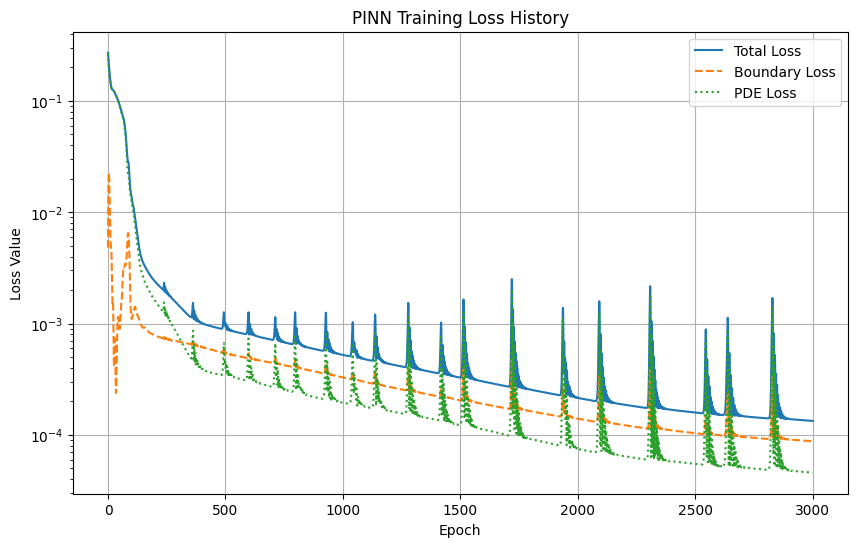

In [26]:
# Optimizer (Adam is common)
optimizer = optim.Adam(pinn_model.parameters(), lr=1e-3)
# Consider using LBFGS for potentially better convergence in later stages (more complex to implement)

# Training parameters
epochs = 3000 # PINNs often require more epochs than standard supervised learning
print_every = 500

# Lists to store loss history
loss_history = []
loss_bc_history = []
loss_pde_history = []

start_train_time = time.time()

for epoch in range(epochs):
    pinn_model.train() # Set model to training mode

    # Zero gradients
    optimizer.zero_grad()

    # Calculate loss
    total_loss, loss_bc, loss_pde = pinn_loss_function(
        pinn_model, xy_boundary, u_boundary_target, xy_pde, a_pinn, b_pinn
    )

    # Backward pass and optimize
    total_loss.backward() # Compute gradients
    optimizer.step()      # Update weights

    # Store losses
    loss_history.append(total_loss.item())
    loss_bc_history.append(loss_bc.item())
    loss_pde_history.append(loss_pde.item())

    # Print progress
    if (epoch + 1) % print_every == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss.item():.6f}, BC Loss: {loss_bc.item():.6f}, PDE Loss: {loss_pde.item():.6f}")

end_train_time = time.time()
print(f"Training finished. Time taken: {end_train_time - start_train_time:.2f} seconds")

# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Total Loss')
plt.plot(loss_bc_history, label='Boundary Loss', linestyle='--')
plt.plot(loss_pde_history, label='PDE Loss', linestyle=':')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yscale('log') # Log scale often useful for PINN loss
plt.title('PINN Training Loss History')
plt.legend()
plt.grid(True)
plt.savefig('figure_pinn_loss_history.png', dpi=150, bbox_inches='tight')
plt.show()

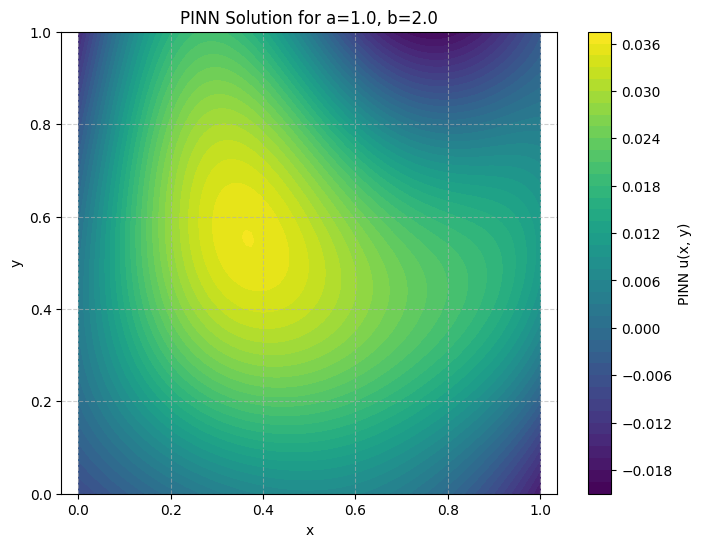


Could not generate comparison plot: operands could not be broadcast together with shapes (100,100) (50,50) 


In [18]:
# Generate a grid for visualization
N_vis = 100
x_vis = torch.linspace(0, 1, N_vis, device=device)
y_vis = torch.linspace(0, 1, N_vis, device=device)
X_vis, Y_vis = torch.meshgrid(x_vis, y_vis, indexing='xy')
xy_vis = torch.stack([X_vis.flatten(), Y_vis.flatten()], dim=1)

# Predict solution on the visualization grid
pinn_model.eval()
with torch.no_grad():
    u_pinn_pred = pinn_model(xy_vis)

# Reshape for plotting
U_pinn_pred = u_pinn_pred.reshape(N_vis, N_vis).cpu().numpy()
X_vis_np = X_vis.cpu().numpy()
Y_vis_np = Y_vis.cpu().numpy()

# --- Plot the PINN solution ---
plt.figure(figsize=(8, 6))
contour = plt.contourf(X_vis_np, Y_vis_np, U_pinn_pred, 50, cmap='viridis')
plt.colorbar(contour, label='PINN u(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'PINN Solution for a={a_pinn}, b={b_pinn}')
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('figure_pinn_solution.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Optional: Compare with Finite Difference Solution (if generated earlier) ---
# Assuming 'u_full' from Cell 7 of the original notebook (for a=1, b=2) is available
# If not, you might need to re-run that part or load it.
try:
    # u_full should be the N x N grid from the FD solver for a=1, b=2
    # We need the grid X, Y from the FD solver too (size N x N)
    N_fd = N # Assuming N=50 from original notebook
    x_fd = np.linspace(0, 1.0, N_fd)
    y_fd = np.linspace(0, 1.0, N_fd)
    X_fd, Y_fd = np.meshgrid(x_fd, y_fd)
    
    # Load or recalculate u_full for a=1, b=2
    # u_full = solve_poisson_for_ab(a_pinn, b_pinn, N=N_fd) # If function is available
    # For now, let's assume u_full exists from previous run
    
    error_pinn_vs_fd = np.abs(U_pinn_pred - u_full) # Need interpolation if grids differ; assume N_vis=N_fd here for simplicity (adjust N_vis if needed)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Comparison: PINN vs Finite Difference (a={a_pinn}, b={b_pinn})', y=1.02)

    # Plot PINN
    cf1 = axes[0].contourf(X_vis_np, Y_vis_np, U_pinn_pred, 50, cmap='viridis')
    fig.colorbar(cf1, ax=axes[0], shrink=0.8)
    axes[0].set_title('PINN Solution')
    axes[0].axis('equal')
    axes[0].set_aspect('equal', adjustable='box')

    # Plot Finite Difference
    cf2 = axes[1].contourf(X_fd, Y_fd, u_full, 50, cmap='viridis', vmin=U_pinn_pred.min(), vmax=U_pinn_pred.max()) # Use same scale approx
    fig.colorbar(cf2, ax=axes[1], shrink=0.8)
    axes[1].set_title('Finite Difference Solution')
    axes[1].axis('equal')
    axes[1].set_aspect('equal', adjustable='box')

    # Plot Absolute Error
    cf3 = axes[2].contourf(X_vis_np, Y_vis_np, error_pinn_vs_fd, 50, cmap='plasma')
    fig.colorbar(cf3, ax=axes[2], shrink=0.8)
    axes[2].set_title('|PINN - FD| Error')
    axes[2].axis('equal')
    axes[2].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig('figure_pinn_vs_fd_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calculate MSE between PINN and FD
    mse_pinn_fd = np.mean((U_pinn_pred - u_full)**2)
    print(f"\nMSE between PINN and FD solution: {mse_pinn_fd:.6f}")

except NameError:
    print("\nVariable 'u_full' (Finite Difference solution) not found. Skipping comparison plot.")
except Exception as e:
     print(f"\nCould not generate comparison plot: {e}")

Interpolating FD solution onto visualization grid (100x100)...
Interpolation complete.


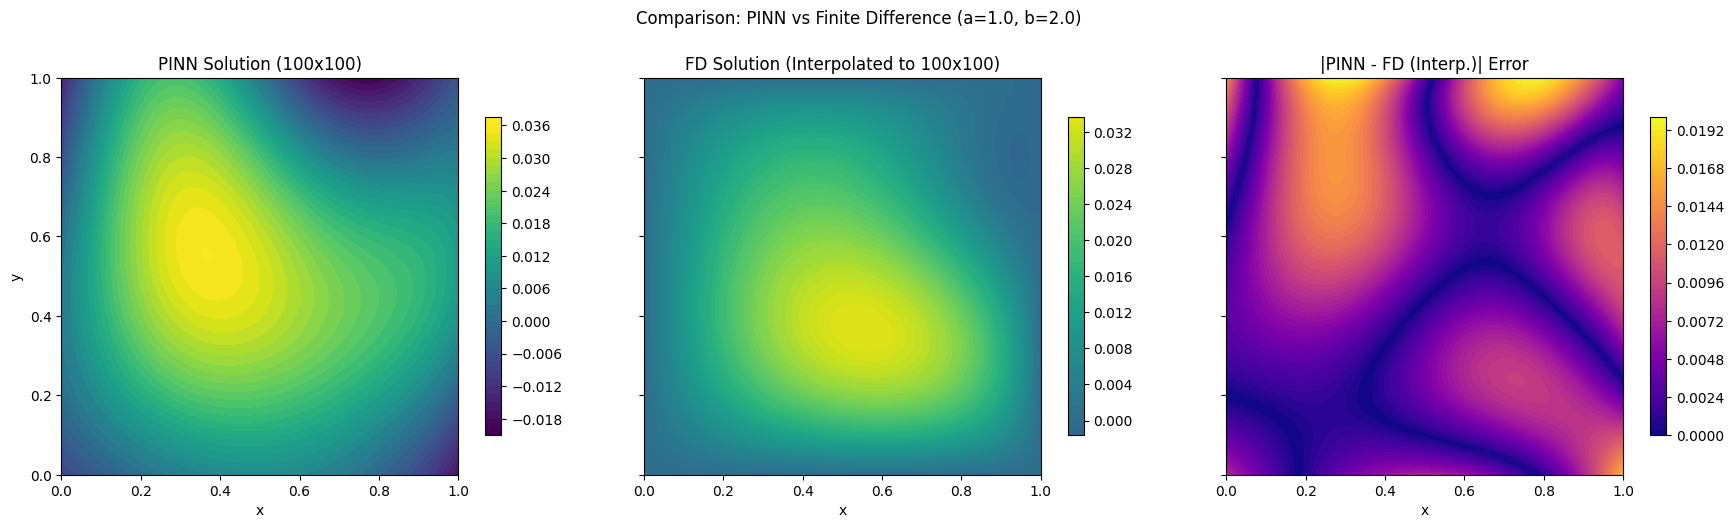


MSE between PINN and Interpolated FD solution: 0.000054


In [19]:
# --- Optional: Compare with Finite Difference Solution (if generated earlier) ---
# Assuming 'u_full' from Cell 7 of the original notebook (for a=1, b=2) is available
# and variable N=50 from the FD part is also defined.
try:
    from scipy.interpolate import griddata # Import griddata

    # FD grid details (assuming N=50)
    N_fd = N 
    x_fd = np.linspace(0, 1.0, N_fd)
    y_fd = np.linspace(0, 1.0, N_fd)
    X_fd, Y_fd = np.meshgrid(x_fd, y_fd)
    
    # Load or ensure u_full (shape 50x50 for a=1, b=2) exists
    # Example: u_full = solve_poisson_for_ab(a_pinn, b_pinn, N=N_fd) # Recalculate if needed

    # PINN visualization grid details (N_vis=100)
    # Assumes X_vis_np, Y_vis_np (shape 100x100) and U_pinn_pred (shape 100x100) exist

    # --- Interpolation Step ---
    # Points where FD data is known (flattened 50x50 grid)
    points_fd = np.stack([X_fd.flatten(), Y_fd.flatten()], axis=1) 
    values_fd = u_full.flatten()
    
    # Grid where we want to interpolate (flattened 100x100 PINN grid)
    points_vis = np.stack([X_vis_np.flatten(), Y_vis_np.flatten()], axis=1)
    
    # Interpolate the FD solution onto the PINN visualization grid
    print("Interpolating FD solution onto visualization grid (100x100)...")
    # Common methods: 'linear', 'cubic', 'nearest'
    u_full_interp_flat = griddata(points_fd, values_fd, points_vis, method='cubic') 
    
    # Reshape interpolated data back to grid (100x100)
    U_full_interp_grid = u_full_interp_flat.reshape((N_vis, N_vis))
    
    # Handle potential NaNs introduced by cubic interpolation near boundaries
    U_full_interp_grid = np.nan_to_num(U_full_interp_grid) 
    print("Interpolation complete.")
    
    # Calculate error between PINN prediction and *interpolated* FD solution
    # Now both arrays have shape (100, 100)
    error_pinn_vs_fd = np.abs(U_pinn_pred - U_full_interp_grid) 

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Comparison: PINN vs Finite Difference (a={a_pinn}, b={b_pinn})', y=1.02)

    # Plot PINN (100x100)
    vmin = min(U_pinn_pred.min(), U_full_interp_grid.min()) # Consistent color scale
    vmax = max(U_pinn_pred.max(), U_full_interp_grid.max())
    cf1 = axes[0].contourf(X_vis_np, Y_vis_np, U_pinn_pred, 50, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cf1, ax=axes[0], shrink=0.8)
    axes[0].set_title('PINN Solution (100x100)')
    axes[0].set_xlabel('x'); axes[0].set_ylabel('y')
    axes[0].axis('equal'); axes[0].set_aspect('equal', adjustable='box')

    # Plot *Interpolated* Finite Difference (100x100)
    cf2 = axes[1].contourf(X_vis_np, Y_vis_np, U_full_interp_grid, 50, cmap='viridis', vmin=vmin, vmax=vmax) 
    fig.colorbar(cf2, ax=axes[1], shrink=0.8)
    axes[1].set_title('FD Solution (Interpolated to 100x100)')
    axes[1].set_xlabel('x'); axes[1].tick_params(axis='y', labelleft=False)
    axes[1].axis('equal'); axes[1].set_aspect('equal', adjustable='box')

    # Plot Absolute Error (|PINN - FD_interp|)
    error_vmax = error_pinn_vs_fd.max()
    cf3 = axes[2].contourf(X_vis_np, Y_vis_np, error_pinn_vs_fd, 50, cmap='plasma', vmin=0, vmax=error_vmax) 
    fig.colorbar(cf3, ax=axes[2], shrink=0.8)
    axes[2].set_title('|PINN - FD (Interp.)| Error')
    axes[2].set_xlabel('x'); axes[2].tick_params(axis='y', labelleft=False)
    axes[2].axis('equal'); axes[2].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig('figure_pinn_vs_fd_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calculate MSE between PINN and *interpolated* FD
    mse_pinn_fd_interp = np.mean((U_pinn_pred - U_full_interp_grid)**2)
    print(f"\nMSE between PINN and Interpolated FD solution: {mse_pinn_fd_interp:.6f}")

except NameError as e:
    print(f"\nVariable 'u_full' (FD solution) or 'N' (FD grid size) not found. Skipping comparison plot. Error: {e}")
except ImportError:
    print("\nScipy not found. Cannot perform interpolation. Skipping comparison plot.")
    print("Please install scipy: pip install scipy")
except Exception as e:
     print(f"\nCould not generate comparison plot: {e}")

In [29]:
# Cell 7 (PINN): Calculate Final PDE Residual

# Ensure the trained pinn_model and collocation points xy_pde exist
# Also need the fixed parameters a_pinn, b_pinn
# Make sure device is defined

# Set the model to evaluation mode
pinn_model.eval()

# Calculate the loss components on the PDE collocation points using the trained model
# We need gradients for this calculation, so we don't use torch.no_grad() here.

# Clone inputs to ensure they require gradients for this specific evaluation
x_pde_eval = xy_pde[:, 0:1].clone().requires_grad_(True)
y_pde_eval = xy_pde[:, 1:2].clone().requires_grad_(True)
xy_pde_input_eval = torch.cat([x_pde_eval, y_pde_eval], dim=1)

# Get model prediction for these points
u_pred_pde_eval = pinn_model(xy_pde_input_eval)

# Calculate derivatives using autograd
# First derivatives: u_x, u_y
# create_graph=True is necessary here to allow calculation of second derivatives
grads_eval = torch.autograd.grad(u_pred_pde_eval, xy_pde_input_eval, 
                            grad_outputs=torch.ones_like(u_pred_pde_eval), 
                            create_graph=True)[0] 

u_x_eval = grads_eval[:, 0:1]
u_y_eval = grads_eval[:, 1:2]

# Second derivatives: u_xx, u_yy
# Calculate u_xx. We need to retain the graph used to compute u_x_eval 
# because u_y_eval comes from the same initial gradient calculation.
u_xx_eval = torch.autograd.grad(u_x_eval, x_pde_eval, 
                           grad_outputs=torch.ones_like(u_x_eval), 
                           retain_graph=True,  # <<< FIX: Keep graph for the next grad call
                           create_graph=False)[0] # create_graph=False is ok here if only evaluating residual

# Calculate u_yy. Now it can reuse the graph portions retained by the u_xx calculation.
# No need to retain graph after this final derivative calculation.
u_yy_eval = torch.autograd.grad(u_y_eval, y_pde_eval, 
                           grad_outputs=torch.ones_like(u_y_eval), 
                           retain_graph=False, # Can be False now
                           create_graph=False)[0]

# Calculate Laplacian and source term
laplacian_u_eval = u_xx_eval + u_yy_eval
f_pde_eval = source_term_torch(x_pde_eval, y_pde_eval, a_pinn, b_pinn)

# Calculate PDE residual: R = -nabla^2 u - f = 0 => R = -laplacian_u_eval - f_pde_eval
residual_pde_values = -laplacian_u_eval - f_pde_eval 

# Calculate final residual metrics
final_loss_pde_mse = torch.mean(residual_pde_values**2)
final_loss_pde_mae = torch.mean(torch.abs(residual_pde_values))
final_loss_pde_rms = torch.sqrt(final_loss_pde_mse)

# Detach and move to CPU for printing
final_loss_pde_mse_item = final_loss_pde_mse.item()
final_loss_pde_mae_item = final_loss_pde_mae.item()
final_loss_pde_rms_item = final_loss_pde_rms.item()

print(f"\nPINN Final PDE Residual Metrics (evaluated on {N_pde} interior points):")
print(f"  MSE Residual (loss_pde): {final_loss_pde_mse_item:.6f}")
print(f"  MAE Residual:            {final_loss_pde_mae_item:.6f}")
print(f"  RMS Residual (sqrt(MSE)):{final_loss_pde_rms_item:.6f}")

# Compare final MSE residual loss to the last one recorded during training
# if loss_pde_history: # Check if training history exists
#      print(f"  (Comparison: Last training PDE loss = {loss_p


PINN Final PDE Residual Metrics (evaluated on 10000 interior points):
  MSE Residual (loss_pde): 0.000046
  MAE Residual:            0.004998
  RMS Residual (sqrt(MSE)):0.006761


In [ ]:
# -*- coding: utf-8 -*-
"""
Script pour comparer les performances d'un PINN et d'un GNN
pour résoudre l'équation de Poisson paramétrée.
"""

import numpy as np
import time
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import os.path as osp

# --- Configuration Globale ---
N = 50  # Taille de la grille (doit correspondre à l'entraînement)
L = 1.0 # Taille du domaine
h = L / (N - 1) # Pas spatial
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du périphérique : {device}")

# Coordonnées de la grille (utilisées plusieurs fois)
x_np = np.linspace(0, L, N)
y_np = np.linspace(0, L, N)
X_np, Y_np = np.meshgrid(x_np, y_np)
N_internal = N - 2
total_internal_nodes = N_internal * N_internal

# --- Solveur par Différences Finies (Référence) ---

def source_term(x, y, a, b):
    """Calcule le terme source f(x, y; a, b)."""
    return x * np.sin(a * np.pi * y) + y * np.sin(b * np.pi * x)

# Pré-calcul de la matrice A des différences finies (si N est constant)
print("Pré-calcul de la matrice A des différences finies...")
A_fd = lil_matrix((total_internal_nodes, total_internal_nodes))
for i in range(N_internal):
    for j in range(N_internal):
        row_idx = i * N_internal + j
        A_fd[row_idx, row_idx] = 4
        if i > 0: A_fd[row_idx, (i - 1) * N_internal + j] = -1
        if i < N_internal - 1: A_fd[row_idx, (i + 1) * N_internal + j] = -1
        if j > 0: A_fd[row_idx, i * N_internal + (j - 1)] = -1
        if j < N_internal - 1: A_fd[row_idx, i * N_internal + (j + 1)] = -1
A_fd = A_fd / (h**2)
A_csc_fd = A_fd.tocsc()
print("Matrice A pré-calculée.")

def solve_poisson_fd(a_val, b_val, N=N, h=h, N_internal=N_internal, A_csc=A_csc_fd):
    """Résout l'équation de Poisson par différences finies pour a, b donnés."""
    # Calcul du terme source sur les nœuds internes
    f_internal = np.zeros((N_internal, N_internal))
    for i in range(N_internal):
        for j in range(N_internal):
            x_coord = x_np[i + 1]
            y_coord = y_np[j + 1]
            f_internal[i, j] = source_term(x_coord, y_coord, a_val, b_val)
    f_vec = f_internal.flatten()

    # Résolution du système linéaire
    u_vec = spsolve(A_csc, f_vec)

    # Remise en forme et ajout des conditions aux limites nulles
    u_internal = u_vec.reshape((N_internal, N_internal))
    u_full = np.zeros((N, N))
    u_full[1:-1, 1:-1] = u_internal
    return u_full

# --- Définitions des Modèles (doivent correspondre aux modèles entraînés) ---

# Définition du PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Assurez-vous que cette architecture correspond exactement à celle sauvegardée
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, y):
        input_tensor = torch.cat([x, y], dim=1)
        return self.net(input_tensor)

# Définition du GNN
class GNN_PoissonSolver(torch.nn.Module):
    def __init__(self, node_features_in=3, node_features_hidden=64, node_features_out=1):
        super(GNN_PoissonSolver, self).__init__()
         # Assurez-vous que cette architecture correspond exactement à celle sauvegardée
        self.conv1 = GCNConv(node_features_in, node_features_hidden)
        self.conv2 = GCNConv(node_features_hidden, node_features_hidden)
        self.conv3 = GCNConv(node_features_hidden, node_features_out)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Note: Le dropout n'est généralement pas utilisé pendant l'évaluation
        # x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

# --- Fonctions Utilitaires ---

def grid_to_graph(u_solution, f_source, N, h):
    """Convertit une grille de simulation en objet PyG Data."""
    num_nodes = N * N
    x_coords = X_np.flatten()
    y_coords = Y_np.flatten()
    f_values = f_source.flatten()
    u_values = u_solution.flatten() # Cible 'y'

    # Caractéristiques des nœuds : [coord_x, coord_y, valeur_f]
    node_features = torch.tensor(np.stack([x_coords, y_coords, f_values], axis=-1), dtype=torch.float32)

    # Arêtes : Connexion des nœuds adjacents (4-connectivité)
    edge_list = []
    for i in range(N):
        for j in range(N):
            node_idx = i * N + j
            if j < N - 1: # Voisin de droite
                neighbor_idx = i * N + (j + 1)
                edge_list.extend([[node_idx, neighbor_idx], [neighbor_idx, node_idx]])
            if i < N - 1: # Voisin du bas
                neighbor_idx = (i + 1) * N + j
                edge_list.extend([[node_idx, neighbor_idx], [neighbor_idx, node_idx]])

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    # Valeurs cibles (solution u)
    y = torch.tensor(u_values, dtype=torch.float32).unsqueeze(1)

    return Data(x=node_features, edge_index=edge_index, y=y)

def prepare_test_case(a_test, b_test, N=N, L=L, h=h):
    """Prépare les données d'un cas test pour les deux modèles."""
    print(f"Préparation du cas test pour a={a_test}, b={b_test}...")
    # Solution de référence par différences finies
    u_fd = solve_poisson_fd(a_test, b_test, N=N, h=h)
    f_source_full = source_term(X_np, Y_np, a_test, b_test) # Terme source sur toute la grille

    # Préparation des données pour PINN (grille de coordonnées)
    x_eval_pinn = torch.tensor(X_np.flatten()[:, None], dtype=torch.float32)
    y_eval_pinn = torch.tensor(Y_np.flatten()[:, None], dtype=torch.float32)

    # Préparation des données pour GNN (graphe)
    graph_data = grid_to_graph(u_fd, f_source_full, N, h)

    print("Cas test préparé.")
    return {
        'a': a_test,
        'b': b_test,
        'x_eval_pinn': x_eval_pinn,
        'y_eval_pinn': y_eval_pinn,
        'graph_gnn': graph_data,
        'true_solution_fd': u_fd
    }

# --- Classe de Comparaison ---

class ModelComparator:
    def __init__(self, N=N, L=L):
        self.N = N
        self.L = L
        self.X_np, self.Y_np = X_np, Y_np # Utiliser les grilles globales
        self.device = device

    def evaluate_models(self, model_pinn, model_gnn, test_data):
        """Évalue les modèles PINN et GNN sur un cas test."""
        print("Évaluation des modèles...")
        results = {
            'a': test_data['a'],
            'b': test_data['b'],
            'true_solution_fd': test_data['true_solution_fd'],
            'pinn': {'pred': None, 'time': 0, 'mse': 0, 'mae': 0},
            'gnn': {'pred': None, 'time': 0, 'mse': 0, 'mae': 0}
        }

        # --- Évaluation PINN ---
        model_pinn.eval().to(self.device)
        x_eval = test_data['x_eval_pinn'].to(self.device)
        y_eval = test_data['y_eval_pinn'].to(self.device)

        start_time = time.time()
        with torch.no_grad():
            pinn_pred_flat = model_pinn(x_eval, y_eval)
        results['pinn']['time'] = time.time() - start_time
        results['pinn']['pred'] = pinn_pred_flat.cpu().numpy().reshape((self.N, self.N))

        # --- Évaluation GNN ---
        model_gnn.eval().to(self.device)
        test_graph = test_data['graph_gnn'].to(self.device)

        start_time = time.time()
        with torch.no_grad():
            gnn_pred_flat = model_gnn(test_graph)
        results['gnn']['time'] = time.time() - start_time
        results['gnn']['pred'] = gnn_pred_flat.cpu().numpy().reshape((self.N, self.N))

        # --- Calcul des métriques ---
        true_solution = results['true_solution_fd']
        for model_type in ['pinn', 'gnn']:
            pred = results[model_type]['pred']
            results[model_type]['mse'] = np.mean((pred - true_solution)**2)
            results[model_type]['mae'] = np.mean(np.abs(pred - true_solution))
            print(f"  {model_type.upper()} - Temps: {results[model_type]['time']:.4f}s, MSE: {results[model_type]['mse']:.6e}, MAE: {results[model_type]['mae']:.6e}")

        print("Évaluation terminée.")
        return results

    def plot_comparison(self, results, save_path='figure_comparaison_pinn_gnn.png'):
        """Visualise les résultats de la comparaison."""
        print("Génération des figures de comparaison...")
        a_val = results['a']
        b_val = results['b']
        true_sol = results['true_solution_fd']
        pinn_pred = results['pinn']['pred']
        gnn_pred = results['gnn']['pred']
        pinn_error = np.abs(pinn_pred - true_sol)
        gnn_error = np.abs(gnn_pred - true_sol)

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f'Comparaison PINN vs GNN pour a={a_val}, b={b_val}', fontsize=16)

        # Trouver les limites communes pour les barres de couleur des solutions
        vmin_sol = min(true_sol.min(), pinn_pred.min(), gnn_pred.min())
        vmax_sol = max(true_sol.max(), pinn_pred.max(), gnn_pred.max())

        # Trouver les limites communes pour les barres de couleur des erreurs
        vmin_err = 0 # L'erreur absolue est toujours >= 0
        vmax_err = max(pinn_error.max(), gnn_error.max())

        # Plot 1: Solution Vraie (FD)
        im1 = axes[0, 0].contourf(self.X_np, self.Y_np, true_sol, 50, cmap='viridis', vmin=vmin_sol, vmax=vmax_sol)
        axes[0, 0].set_title('Solution Vraie (Différences Finies)')
        axes[0, 0].set_xlabel('x')
        axes[0, 0].set_ylabel('y')
        axes[0, 0].axis('equal')
        fig.colorbar(im1, ax=axes[0, 0])

        # Plot 2: Prédiction PINN
        im2 = axes[0, 1].contourf(self.X_np, self.Y_np, pinn_pred, 50, cmap='viridis', vmin=vmin_sol, vmax=vmax_sol)
        axes[0, 1].set_title('Prédiction PINN')
        axes[0, 1].set_xlabel('x')
        axes[0, 1].set_ylabel('y')
        axes[0, 1].axis('equal')
        fig.colorbar(im2, ax=axes[0, 1])

        # Plot 3: Prédiction GNN
        im3 = axes[0, 2].contourf(self.X_np, self.Y_np, gnn_pred, 50, cmap='viridis', vmin=vmin_sol, vmax=vmax_sol)
        axes[0, 2].set_title('Prédiction GNN')
        axes[0, 2].set_xlabel('x')
        axes[0, 2].set_ylabel('y')
        axes[0, 2].axis('equal')
        fig.colorbar(im3, ax=axes[0, 2])

        # Plot 4: Erreur Absolue PINN
        im4 = axes[1, 0].contourf(self.X_np, self.Y_np, pinn_error, 50, cmap='plasma', vmin=vmin_err, vmax=vmax_err)
        axes[1, 0].set_title('Erreur Absolue PINN (|Pred - Vrai|)')
        axes[1, 0].set_xlabel('x')
        axes[1, 0].set_ylabel('y')
        axes[1, 0].axis('equal')
        fig.colorbar(im4, ax=axes[1, 0])

        # Plot 5: Erreur Absolue GNN
        im5 = axes[1, 1].contourf(self.X_np, self.Y_np, gnn_error, 50, cmap='plasma', vmin=vmin_err, vmax=vmax_err)
        axes[1, 1].set_title('Erreur Absolue GNN (|Pred - Vrai|)')
        axes[1, 1].set_xlabel('x')
        axes[1, 1].set_ylabel('y')
        axes[1, 1].axis('equal')
        fig.colorbar(im5, ax=axes[1, 1])

        # Plot 6: Métriques et Temps
        ax_metrics = axes[1, 2]
        metrics_text = (
            f"PINN:\n"
            f"  MSE: {results['pinn']['mse']:.4e}\n"
            f"  MAE: {results['pinn']['mae']:.4e}\n"
            f"  Temps: {results['pinn']['time']:.4f}s\n\n"
            f"GNN:\n"
            f"  MSE: {results['gnn']['mse']:.4e}\n"
            f"  MAE: {results['gnn']['mae']:.4e}\n"
            f"  Temps: {results['gnn']['time']:.4f}s"
        )
        ax_metrics.text(0.05, 0.95, metrics_text, transform=ax_metrics.transAxes,
                        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.5))
        ax_metrics.set_title('Métriques Comparatives')
        ax_metrics.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuster pour le titre principal
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure de comparaison sauvegardée sous : {save_path}")
        plt.show()

    def plot_overall_metrics(self, results_list, save_path='figure_comparaison_globale.png'):
        """Génère un graphique comparant les métriques moyennes sur plusieurs cas tests."""
        print("Génération de la figure des métriques globales...")
        pinn_mses = [r['pinn']['mse'] for r in results_list]
        gnn_mses = [r['gnn']['mse'] for r in results_list]
        pinn_maes = [r['pinn']['mae'] for r in results_list]
        gnn_maes = [r['gnn']['mae'] for r in results_list]
        pinn_times = [r['pinn']['time'] for r in results_list]
        gnn_times = [r['gnn']['time'] for r in results_list]
        labels = [f"a={r['a']}, b={r['b']}" for r in results_list]

        x = np.arange(len(labels))
        width = 0.35

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Comparaison Globale des Performances PINN vs GNN', fontsize=16)

        # MSE Plot (échelle log)
        rects1 = axes[0].bar(x - width/2, pinn_mses, width, label='PINN', color='skyblue')
        rects2 = axes[0].bar(x + width/2, gnn_mses, width, label='GNN', color='lightcoral')
        axes[0].set_ylabel('MSE (log scale)')
        axes[0].set_title('Erreur Quadratique Moyenne (MSE)')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(labels, rotation=45, ha="right")
        axes[0].set_yscale('log')
        axes[0].legend()
        axes[0].grid(True, which="both", ls="--", alpha=0.6)

        # MAE Plot (échelle log)
        rects3 = axes[1].bar(x - width/2, pinn_maes, width, label='PINN', color='skyblue')
        rects4 = axes[1].bar(x + width/2, gnn_maes, width, label='GNN', color='lightcoral')
        axes[1].set_ylabel('MAE (log scale)')
        axes[1].set_title('Erreur Absolue Moyenne (MAE)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(labels, rotation=45, ha="right")
        axes[1].set_yscale('log')
        axes[1].legend()
        axes[1].grid(True, which="both", ls="--", alpha=0.6)

        # Temps d'inférence Plot
        rects5 = axes[2].bar(x - width/2, pinn_times, width, label='PINN', color='skyblue')
        rects6 = axes[2].bar(x + width/2, gnn_times, width, label='GNN', color='lightcoral')
        axes[2].set_ylabel('Temps (secondes)')
        axes[2].set_title("Temps d'inférence")
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(labels, rotation=45, ha="right")
        axes[2].legend()
        axes[2].grid(True, axis='y', ls="--", alpha=0.6)

        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure des métriques globales sauvegardée sous : {save_path}")
        plt.show()


# --- Exécution Principale ---
if __name__ == "__main__":
    # --- Paramètres ---
    PINN_MODEL_PATH = 'model_pinn.pt'
    GNN_MODEL_PATH = 'model_gnn.pt'
    TEST_CASES = [
        {'a': 1.0, 'b': 2.0},
        {'a': 0.5, 'b': 0.5},
        {'a': 2.5, 'b': 1.5},
        {'a': 1.8, 'b': 2.8}
        # Ajoutez d'autres cas tests si nécessaire
    ]
    SAVE_FIG_COMPARISON_PREFIX = 'figure_comparaison'
    SAVE_FIG_OVERALL = 'figure_comparaison_globale.png'

    # --- Vérifier l'existence des fichiers modèles ---
    if not osp.exists(PINN_MODEL_PATH):
        print(f"ERREUR : Fichier modèle PINN non trouvé : {PINN_MODEL_PATH}")
        print("Veuillez entraîner et sauvegarder le modèle PINN d'abord.")
        exit()
    if not osp.exists(GNN_MODEL_PATH):
        print(f"ERREUR : Fichier modèle GNN non trouvé : {GNN_MODEL_PATH}")
        print("Veuillez entraîner et sauvegarder le modèle GNN d'abord.")
        exit()

    # --- Charger les modèles ---
    print("Chargement des modèles pré-entraînés...")
    try:
        # Charger avec map_location pour gérer CPU/GPU
        model_pinn = torch.load(PINN_MODEL_PATH, map_location=device)
        model_gnn = torch.load(GNN_MODEL_PATH, map_location=device)
        print("Modèles chargés avec succès.")
    except Exception as e:
        print(f"Erreur lors du chargement des modèles : {e}")
        print("Assurez-vous que les fichiers .pt existent et contiennent les bonnes architectures.")
        exit()

    # --- Initialiser le comparateur ---
    comparator = ModelComparator(N=N, L=L)

    # --- Boucle sur les cas tests ---
    all_results = []
    for i, case in enumerate(TEST_CASES):
        a_test = case['a']
        b_test = case['b']
        print(f"\n--- Traitement du Cas Test {i+1}: a={a_test}, b={b_test} ---")

        # Préparer les données pour ce cas
        test_data = prepare_test_case(a_test, b_test, N=N, L=L, h=h)

        # Évaluer les modèles
        results = comparator.evaluate_models(model_pinn, model_gnn, test_data)
        all_results.append(results)

        # Générer la figure de comparaison pour ce cas
        save_path_case = f"{SAVE_FIG_COMPARISON_PREFIX}_a{a_test}_b{b_test}.png"
        comparator.plot_comparison(results, save_path=save_path_case)

    # --- Générer la figure de comparaison globale ---
    if len(all_results) > 1:
        comparator.plot_overall_metrics(all_results, save_path=SAVE_FIG_OVERALL)
    elif len(all_results) == 1:
        print("\nUne seule étude de cas a été réalisée. Le graphique comparatif global n'a pas été généré.")

    print("\nScript de comparaison terminé.")
